# Tutorial 2: Computing Molecular Charge densities

In this tutorial, we will consider an example of using Python classes. 

As an example, we will construct a data type `molecule` which stores the types and number of elements it contains as well as a charge density in a given grid. The charge density will be computed using *pre-computed* elemental charge densities, which will be superposed. The charge density at an arbitrary point will be computed using interpolation. The [InterpolatedUnivariateSpline](https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.interpolate.InterpolatedUnivariateSpline.html) function from the Scipy package will be used for this purpose.

In [1]:
import numpy as np
from utils import utils # Notice how we import our own module
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.interpolate import InterpolatedUnivariateSpline

%matplotlib inline

Let's first specify the folder where the pre-computed charge densities for elements are located:

In [2]:
# PP folder
pp_folder = 'PP'

You can call shell commands from a notebook using `!`. For example, let's list the contents of `PP`:

In [3]:
!ls PP

C.pbe-n-rrkjus_psl.0.1.UPF H.pbe-rrkjus_psl.0.1.UPF


Let's plot the precomputed charge densities:

In [4]:
elements = {'H':'H.pbe-rrkjus_psl.0.1.UPF', 'C':'C.pbe-n-rrkjus_psl.0.1.UPF'} 

# Assign the path to each element file 
path_to_H = os.path.join(pp_folder,elements['H'])
path_to_C = os.path.join(pp_folder,elements['C'])

# Use the utilities to read the radial charge density as well as the radial grid:
rho_H, r_H = utils.getPP(path_to_H)
rho_C, r_C = utils.getPP(path_to_C)

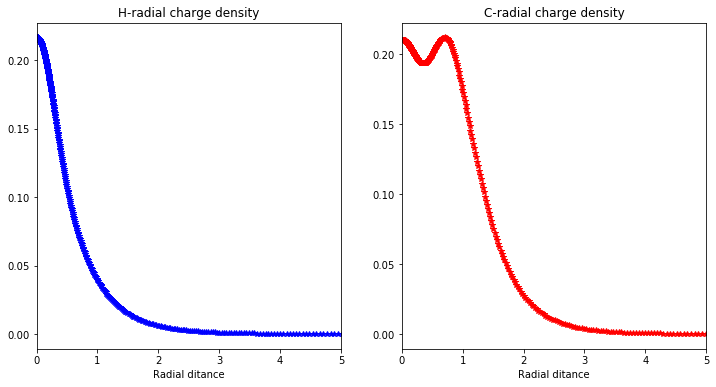

In [5]:
# Setup plot
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
ax1.plot(r_H, rho_H, 'b*')
ax2.plot(r_C, rho_C, 'r*')
ax1.set_xlim([0,5])
ax2.set_xlim([0,5])
ax1.set_xlabel('Radial ditance')
ax2.set_xlabel('Radial ditance')
ax1.set_title('H-radial charge density')
ax2.set_title('C-radial charge density')
plt.show()

## Construct a molecule class for computing charge density on a grid

Compute charge density on a grid of points ${\bf r}$ using a superposition of charge densities of elements (this is a good first approximation to the actual charge density):

$$ \rho ({\bf r}) = \sum_{a=0}^{N}\, \rho_a ( \vert {\bf r} - {\bf r}_a \vert) $$

where $\rho_a$ is the charge density for a given atom with label "a". In order to achieve this, we need to perform the following steps:

1. Read the structure of the molecule from file
2. For each element in the molecule, read its pre-computed charge density
3. Construct an interpolation function which can determine the charge density at an arbitrary point
4. Supply a grid of points (n,n,n) where the charge density will be computed
5. Compute the charge density on this grid
 

<img src="img/density.png" alt="Drawing" style="width: 600px;"/>

The above figure shows what we are trying to do schematically. The (valence) charge density of each atom is spherically symmetric, and we will use a rectangular grid of points to compute the molecular charge density. 

The grid will contain points that are not originally in the radial grid that we have read from file for each atom. We will need to interpolate. 

The `molecule` class below contains the data (charge density) and *methods* (i.e. functions) that process this data. The application programming interface (API) of this class can be summarized as follows:

```python
class Molecule(object):
    def __init__(self, name)   # Constructor
    def read_input(self)       # Method to read atomic charge densities from file
    def interpolate_PP(self)   # Method to interpolate charge densities
    def get_charge_density(self, box, n) # Given a box size, and number of points, compute charge density
```

Below is the implementation:

In [6]:
class Molecule(object):
    def __init__ (self, name):
        self.name = name
        assert os.path.exists(name), "No input for molecule found!"
        
        # Read positions and atomic species from input
        self.read_input()
        
    def read_input(self):
        with open(self.name, 'r') as f:
            lines = f.readlines()
            natoms = 0
            species = {}
            
            for ii,line in enumerate(lines):
                if line.strip() == "ATOMIC_SPECIES":
                    continue
            
                if line.strip() == "ATOMIC_POSITIONS":
                    start_pos = ii
                    break
            
                natoms += int(line.split()[1])
                species[line.split()[0]] = [int(line.split()[1]),float(line.split()[2]), line.split()[3]]
         
    
            # Positions
            pos = np.zeros((natoms,3))
    
            # Read positions
            i = 0
            for l in range(start_pos+1,len(lines)):
                line = lines[l].split()[1:]
                pos[i] = np.array(line)
                i +=1
        
        # Save atomic species, number of atoms and positions in the object
        self.species = species
        self.natoms = natoms
        self.pos = pos / 0.529 # Convert from Angstrom to atomic units
    
    def interpolate_PP(self):
        """ Get interpolated charge density for each species """
        
        dictSplines = {}
        for k, v in self.species.items():
            path_to_pp = os.path.join(pp_folder, v[2])
            radialDensity, radialGrid = utils.getPP(path_to_pp)
            
            # Construct spline and save in the dictionary
            spl = InterpolatedUnivariateSpline(radialGrid, radialDensity)
            dictSplines[k] = spl
        
        self.dictSplines = dictSplines
    
    def get_charge_density(self, box, n):
        """ Construct charge density
            box : Size of the box where the molecule is in (units of a.u.)
            n   : Number of points in one direction. Total number is nxnxn
        """
        # Generate a grid
        ngrid = n**3
        x = np.linspace(0,box,n)
        y = np.linspace(0,box,n)
        z = np.linspace(0,box,n)
        
        grid = np.vstack(np.meshgrid(x,y,z)).reshape(3,-1).T
        self.grid = grid # Save grid in the object for later use
        
        # Get all the masses and elements as a list
        masses = []
        atom_list = []
        for k, v in self.species.items():
            mass = float(v[1])
            masses.extend([mass]*v[0])
            atom_list.extend([k]*v[0])
          
        # Compute center of mass
        r_cm = np.dot(np.array(masses), self.pos) / np.sum(masses)
        
        # Move molecule to the center of the box
        pos = self.pos - r_cm + np.array([box/2.0, box/2.0, box/2.0])
        
        # Obtain the interpolated radial charge densities
        self.interpolate_PP()
        
        # Compute density contribution from each atom
        densityByAtom = np.zeros((self.natoms, n**3)) # Initiate
        
        for iat in range(self.natoms):
            R_at_rel = np.sqrt( (pos[iat,0] - grid[:,0])**2 + (pos[iat,1] - grid[:,1])**2 + 
                                (pos[iat,2] - grid[:,2])**2 )
            
            # Compute the value at the grid points from the spline
            densityByAtom[iat,:] = self.dictSplines[atom_list[iat]](R_at_rel)
        
        # Sum over all atoms
        rho = np.sum(densityByAtom, axis=0)
        
        return rho
            

The input file that we use to read data on the molecule:

In [7]:
!cat benzene 

ATOMIC_SPECIES
C  6 12.0  C.pbe-n-rrkjus_psl.0.1.UPF 
H  6 1.00  H.pbe-rrkjus_psl.0.1.UPF 
ATOMIC_POSITIONS
C       0.0000  1.3970  0.0000
C       1.2098  0.6985  0.0000
C       1.2098 -0.6985  0.0000
C       0.0000 -1.3970  0.0000
C      -1.2098 -0.6985  0.0000
C      -1.2098  0.6985  0.0000
H       0.0000  2.4810  0.0000
H       2.1486  1.2405  0.0000
H       2.1486 -1.2405  0.0000
H       0.0000 -2.4810  0.0000
H      -2.1486 -1.2405  0.0000
H      -2.1486  1.2405  0.0000


In [8]:
# Construct the molecule object
mol = Molecule('benzene')

In [9]:
# Now compute charge density
box = 20
n = 100
rho = mol.get_charge_density(box, n)

Let's look at the first 10 grid points (of 100x100x100)

In [11]:
mol.grid[:10,]

array([[ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.2020202 ],
       [ 0.        ,  0.        ,  0.4040404 ],
       [ 0.        ,  0.        ,  0.60606061],
       [ 0.        ,  0.        ,  0.80808081],
       [ 0.        ,  0.        ,  1.01010101],
       [ 0.        ,  0.        ,  1.21212121],
       [ 0.        ,  0.        ,  1.41414141],
       [ 0.        ,  0.        ,  1.61616162],
       [ 0.        ,  0.        ,  1.81818182]])

Now the ones between 100 to 110:

In [12]:
mol.grid[100:110,:]

array([[ 0.2020202 ,  0.        ,  0.        ],
       [ 0.2020202 ,  0.        ,  0.2020202 ],
       [ 0.2020202 ,  0.        ,  0.4040404 ],
       [ 0.2020202 ,  0.        ,  0.60606061],
       [ 0.2020202 ,  0.        ,  0.80808081],
       [ 0.2020202 ,  0.        ,  1.01010101],
       [ 0.2020202 ,  0.        ,  1.21212121],
       [ 0.2020202 ,  0.        ,  1.41414141],
       [ 0.2020202 ,  0.        ,  1.61616162],
       [ 0.2020202 ,  0.        ,  1.81818182]])

Let's look at the positions:

In [13]:
mol.pos

array([[ 0.        ,  2.64083176,  0.        ],
       [ 2.28695652,  1.32041588,  0.        ],
       [ 2.28695652, -1.32041588,  0.        ],
       [ 0.        , -2.64083176,  0.        ],
       [-2.28695652, -1.32041588,  0.        ],
       [-2.28695652,  1.32041588,  0.        ],
       [ 0.        ,  4.6899811 ,  0.        ],
       [ 4.06162571,  2.34499055,  0.        ],
       [ 4.06162571, -2.34499055,  0.        ],
       [ 0.        , -4.6899811 ,  0.        ],
       [-4.06162571, -2.34499055,  0.        ],
       [-4.06162571,  2.34499055,  0.        ]])

Plot molecular density in this grid at a slice $z=0$:

In [14]:
def plot_density(X_grid, X_rho):
    """ Plotting the density pm3d style """
    # Write density at z = box/2  
    npts = X_grid.shape[0]
    nz = int(npts**(1.0/3.0)//2)

    X = []
    for ipt in range(npts):
        if (np.abs(X_grid[ipt,2]-X_grid[nz,2]) < 1e-6):
            X.append([X_grid[ipt,0], X_grid[ipt,1], X_rho[ipt]])
            
    X_plt = np.array(X)
    x = X_plt[:,0]; y = X_plt[:,1]; z = X_plt[:,2]
    N = int(len(z)**0.5)
    z = z.reshape(N,N)
        
    plt.figure(figsize=(6,6))
    plt.imshow(z, extent=(np.amin(x), np.amax(x), np.amin(y), np.amax(y)),
                 cmap=cm.hot)
        
    
    plt.show()


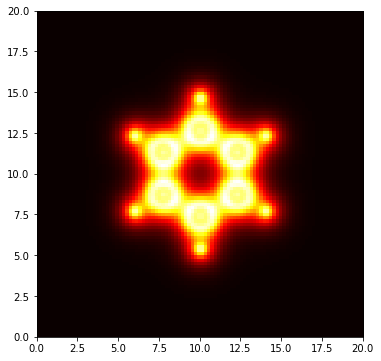

In [15]:
plot_density(mol.grid, rho)

## Compute potential at the center

$$ V(0) = \int_V\, d^3r\, \frac{\rho({\bf r})}{\vert {\bf r} \vert} \approx \frac{V}{N}\, \sum_i\, \frac{\rho({\bf r}_i)}{\vert {\bf r}_i \vert} $$

In [17]:
# Compute the denominator
denom = np.linalg.norm(mol.grid, axis=1)

In [18]:
denom[0] = 1e6 # Add a very large term at 0 to prevent division by 0
v_0 = np.sum(np.divide(rho,denom)) * (box/n)**3
print("Potential at origin = {:.4f}".format(v_0))

Potential at origin = 1.6802


## Exercise

Compute the potential everywhere using Numpy functions (try not to use for loops!)

$$ V({\bf R}) = \frac{V}{N}\, \sum_i\, \frac{\rho({\bf r}_i)}{\vert {\bf R} - {\bf r}_i \vert} $$